# BitTiger DS501 Week 12

1. [FFNN](#5.-Build-model)
2. [RNN](#10.-Build-RNN-model)
3. [Multiple-layers RNN](#11.-Multiple-layers-RNN)
4. [Bi-directional RNN](#12.-Bi-directional RNN)
2. [Pretrained embedding](#13.-Pretrained-embedding)

# Sentiment Analysis using IMDB movie reviews

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, CuDNNLSTM
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling1D

print(tf.__version__)

1.12.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np

## 1. Download IMDB dataset

IMDB reviews 是 sequence of words 已經被轉換成 sequence of integers

```python
def load_data(path='imdb.npz', num_words=None, skip_top=0, maxlen=None, seed=113,
              start_char=1, oov_char=2, index_from=3, **kwargs):
```
oov 表示 out of vocabulary

In [3]:
vocab_size = 10000 # 設定 reviews 中只使用 10,000 常用的字，罕用字會被 oov_char 取代

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=vocab_size)

In [4]:
print(type(train_data), type(train_labels), type(test_data), type(test_labels))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [5]:
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(25000,) (25000,) (25000,) (25000,)


### special words:
* `<PAD>`: padding
* `<SOS>`: start of sentence
* `<UNK>`: unknown

要把這三個加到 imdb 的 word 與 integer 對應的字典裡

In [6]:
word_index = keras.datasets.imdb.get_word_index() # imdb 內建的字典，用來 mapping 單字與對應的整數

# 通常把 <PAD>, <SOS>, <UNK> 加在最前面，所以要把原本的字典對應的整數往後移
word_index = {k:(v+3) for k, v in word_index.items()}

# <PAD>, <SOS>, <UNK> 習慣上對應的數字是 0, 1, 2
word_index['<PAD>'] = 0
word_index['<SOS>'] = 1
word_index['<UNK>'] = 2

### 數字轉換回單字

imdb 只有提供把單字轉成數字的字典，要自己做一個把數字轉回單字的，不然只看數字也不知道是啥

In [7]:
reverse_word_index = {v:k for k, v in word_index.items()} # 數字對應到單字

def decode_review(text):
    words = [reverse_word_index.get(i, '<UNK>') for i in text] # 找不到就傳回 <UNK>
    
    fixed_width_string = []
    max_len = 10
    for w_pos in range(len(words)):
        fixed_width_string.append(words[w_pos])
        if (w_pos + 1) % max_len == 0: # 每 10 個字就一行，要加 1 是因為 index 是從 0 開始算的原故。這一步只是要方便顯示，太長的話不容易閱讀。
            fixed_width_string.append('\n')
    return ' '.join(fixed_width_string)

## 2. 檢查內容是否正確

輸入是代表評論中的單字的整數，輸出是 0 表示負評，輸出是 1 表示好評

### 檢查輸入和輸出的數目是否相等

In [8]:
print('Training dataset: {} reviews, {} labels'.format(len(train_data), len(train_labels)))

Training dataset: 25000 reviews, 25000 labels


### 檢查輸入的內容和 label

In [9]:
print('Word IDs:')
print(train_data[:3]) # 前三條評論，顯示的是整數

for i in range(3):
    print(decode_review(train_data[i])) # 把整數轉回單字看真正的評論寫了什麼，也可以驗證 decode_review() 沒問題
    
print('labels:')
print(train_labels[:3]) # 前三條評論是好評或是負評

Word IDs:
[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5,

## 3. 整理輸入值

每條評論的內容，長度不一樣

In [10]:
print(len(train_data[0]), len(train_data[1]))

218 189


* 要把評論的長度改成一樣長，太短的評論要在前面加上 `<PAD>`
  * 用 `pad_sequences()`
* 用 `maxlen` 設定最常要多長
  * 如果 `maxlen=None` 就會把短的評論的長度拉成跟最長的評論一樣長，利用的方式是在前方填上 `<PAD>`
    * 要指定 `padding='pre'` 表示把 `<PAD>` 加在前面
  * 如果有設定 `maxlen` 那就要設定 `truncating='pre'` 表示太長時要砍掉前面，因為通常重點會在後面

In [11]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data, value=word_index['<PAD>'], padding='pre', truncating='pre', maxlen=100)
test_data  = keras.preprocessing.sequence.pad_sequences(test_data,  value=word_index['<PAD>'], padding='pre', truncating='pre', maxlen=100)

整理好後檢查一下評論是否一樣長了

In [12]:
print(len(train_data[0]), len(train_data[1]))

100 100


看整理過後的評論變怎樣

In [13]:
print(train_data[2])
print(decode_review(train_data[2]))

[1301    4 1873   33   89   78   12   66   16    4  360    7    4   58
  316  334   11    4 1716   43  645  662    8  257   85 1200   42 1228
 2578   83   68 3912   15   36  165 1539  278   36   69    2  780    8
  106   14 6905 1338   18    6   22   12  215   28  610   40    6   87
  326   23 2300   21   23   22   12  272   40   57   31   11    4   22
   47    6 2307   51    9  170   23  595  116  595 1352   13  191   79
  638   89    2   14    9    8  106  607  624   35  534    6  227    7
  129  113]
touching the floor at how bad it really was the 
 rest of the time everyone else in the theatre just 
 started talking to each other leaving or generally crying into 
 their popcorn that they actually paid money they had <UNK> 
 working to watch this feeble excuse for a film it 
 must have looked like a great idea on paper but 
 on film it looks like no one in the film 
 has a clue what is going on crap acting crap 
 costumes i can't get across how <UNK> this is to 
 watch save yourself

較短的評論前方也被加上了 `<PAD>`

In [14]:
print(train_data[5])
print(decode_review(train_data[5]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766 7982 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <SOS> begins better 
 than it ends funny that the russian submarine crew <UNK> 
 all other actors it's like those scenes where documentary 

## 4. 建立 Validation dataset

用前面 1000 筆當作 validation dataset，剩下的才是 training samples

In [15]:
X_validate = train_data[:1000]
y_validate = train_labels[:1000]

X_train = train_data[1000:]
y_train = train_labels[1000:]

## 5. Build model

* 要有幾層？
* 每一層要有多少個神經元？

In [16]:
model = keras.Sequential()
model.add(Embedding(vocab_size, 100)) # 把 10000 個單字 map 到 100 維
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation=tf.nn.relu)) # 只有一層 fully connected 的 hidden layer，用 ReLU 當 activation
model.add(Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


# 6. Train model

In [17]:
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_validate, y_validate))

Train on 24000 samples, validate on 1000 samples
Epoch 1/10
24000/24000 [==============================] - 10s 406us/step - loss: 0.5498 - acc: 0.7565 - val_loss: 0.3721 - val_acc: 0.8240
Epoch 2/10
24000/24000 [==============================] - 10s 405us/step - loss: 0.3089 - acc: 0.8735 - val_loss: 0.3195 - val_acc: 0.8510
Epoch 3/10
24000/24000 [==============================] - 10s 405us/step - loss: 0.2450 - acc: 0.9030 - val_loss: 0.3185 - val_acc: 0.8470
Epoch 4/10
24000/24000 [==============================] - 9s 371us/step - loss: 0.2095 - acc: 0.9179 - val_loss: 0.3269 - val_acc: 0.8470
Epoch 5/10
24000/24000 [==============================] - 9s 382us/step - loss: 0.1847 - acc: 0.9302 - val_loss: 0.3456 - val_acc: 0.8420
Epoch 6/10
24000/24000 [==============================] - 10s 416us/step - loss: 0.1634 - acc: 0.9411 - val_loss: 0.3724 - val_acc: 0.8410
Epoch 7/10
24000/24000 [==============================] - 9s 374us/step - loss: 0.1460 - acc: 0.9497 - val_loss: 0.4128

# 7. Evaluate model

In [18]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 38us/step
[0.5872641475129128, 0.82132]


# 8. Plot

把 loss 和 accuracy 隨著 epoch 變化的走勢畫出來

In [19]:
def plot_hist(history):
    history_dict = history.history
    
    acc = history_dict['acc']
    loss = history_dict['loss']
    
    val_acc = history_dict['val_acc']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot loss
    plt.clf() # clear plot
    plt.plot(epochs, loss, 'bo', label='Train loss') # 'bo': blue dot
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Train and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.clf() # clear plot
    plt.plot(epochs, acc, 'bo', label='Train acc') # 'bo': blue dot
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Train and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

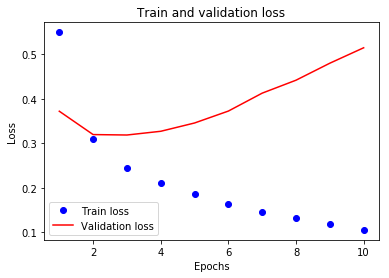

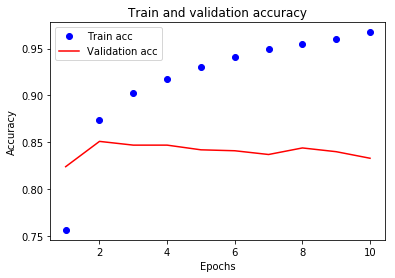

In [20]:
plot_hist(history)

# 9. 處裡 Overfitting


### Build model

使用 `Dropout()` 來處理 overfitting 的問題

In [21]:
# 先清除掉前面的 model
model = None
K.clear_session()

# 在 model 中加上 Dropout() 後重跑一次
model = keras.Sequential()
model.add(Embedding(vocab_size, 100)) # 把 10000 個單字 map 到 100 維
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation=tf.nn.relu)) # 只有一層 fully connected 的 hidden layer，用 ReLU 當 activation
model.add(Dropout(0.5)) # 只有這裡是新的，其他部分維持和原本的一樣
model.add(Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


### Train model and make plot

因為有加上 `Dropout()` ，數據量變少了，所以需要多跑幾個 epochs

Train on 24000 samples, validate on 1000 samples
Epoch 1/20
24000/24000 [==============================] - 9s 390us/step - loss: 0.5821 - acc: 0.7321 - val_loss: 0.4008 - val_acc: 0.8330
Epoch 2/20
24000/24000 [==============================] - 9s 363us/step - loss: 0.3566 - acc: 0.8594 - val_loss: 0.3256 - val_acc: 0.8430
Epoch 3/20
24000/24000 [==============================] - 9s 360us/step - loss: 0.2848 - acc: 0.8900 - val_loss: 0.3142 - val_acc: 0.8470
Epoch 4/20
24000/24000 [==============================] - 9s 361us/step - loss: 0.2484 - acc: 0.9120 - val_loss: 0.3214 - val_acc: 0.8530
Epoch 5/20
24000/24000 [==============================] - 9s 361us/step - loss: 0.2223 - acc: 0.9247 - val_loss: 0.3354 - val_acc: 0.8490
Epoch 6/20
24000/24000 [==============================] - 9s 360us/step - loss: 0.2024 - acc: 0.9354 - val_loss: 0.3526 - val_acc: 0.8450
Epoch 7/20
24000/24000 [==============================] - 9s 362us/step - loss: 0.1801 - acc: 0.9468 - val_loss: 0.3722 - v

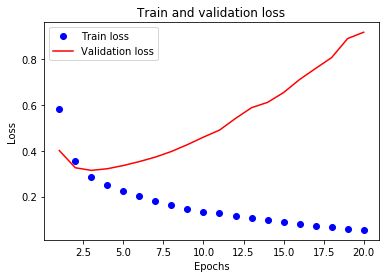

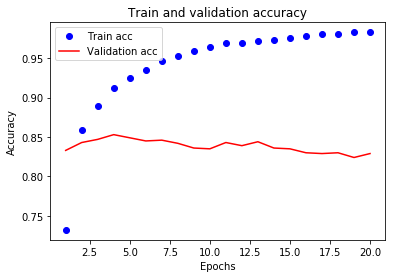

In [22]:
history = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_validate, y_validate))
plot_hist(history)

#### Evaluate model

In [23]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 39us/step
[1.093872824728489, 0.80976]


# 10. Build RNN model

只要把前面 FFNN 的 `Dense()` 拿掉改成 `LSTM()` 或 `CuDNNLSTM()` 就可以了

```python
LSTM(hidden_units, dropout=0.0, recurrent_dropout=0.0)
```

* `hidden_units`: memory 的大小
* `dropout`: 輸入有多少要被 dropout
* `recurrent_dropout`: 前一級的輸出 (就是這一級的 memory) 有多少要被 dropout 

In [24]:
# 先清除掉前面的 model
model = None
K.clear_session()

# 在 model 中加上 Dropout() 後重跑一次
model = keras.Sequential()
model.add(Embedding(vocab_size, 100)) # 把 10000 個單字 map 到 100 維
# 拿掉下面兩層
# model.add(GlobalAveragePooling1D())
# model.add(Dense(16, activation=tf.nn.relu)) # 只有一層 fully connected 的 hidden layer，用 ReLU 當 activation
# 改用 LSTM
model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5))
# 改用 CuDNNLSTM
# model.add(CuDNNLSTM(32)) # mac 上不能跑，因為沒有 CUDA GPU
# model.add(Dropout(0.5)) # 只有這裡是新的，其他部分維持和原本的一樣
model.add(Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


### Train model and make plot

Train on 24000 samples, validate on 1000 samples
Epoch 1/10
24000/24000 [==============================] - 89s 4ms/step - loss: 0.5660 - acc: 0.7108 - val_loss: 0.4444 - val_acc: 0.7890
Epoch 2/10
24000/24000 [==============================] - 84s 4ms/step - loss: 0.4217 - acc: 0.8141 - val_loss: 0.4185 - val_acc: 0.8050
Epoch 3/10
24000/24000 [==============================] - 85s 4ms/step - loss: 0.3737 - acc: 0.8407 - val_loss: 0.4373 - val_acc: 0.7920
Epoch 4/10
24000/24000 [==============================] - 85s 4ms/step - loss: 0.3353 - acc: 0.8592 - val_loss: 0.4280 - val_acc: 0.8070
Epoch 5/10
24000/24000 [==============================] - 85s 4ms/step - loss: 0.3084 - acc: 0.8712 - val_loss: 0.4324 - val_acc: 0.8120
Epoch 6/10
24000/24000 [==============================] - 87s 4ms/step - loss: 0.2965 - acc: 0.8789 - val_loss: 0.4440 - val_acc: 0.8040
Epoch 7/10
24000/24000 [==============================] - 87s 4ms/step - loss: 0.2719 - acc: 0.8912 - val_loss: 0.4627 - val_acc:

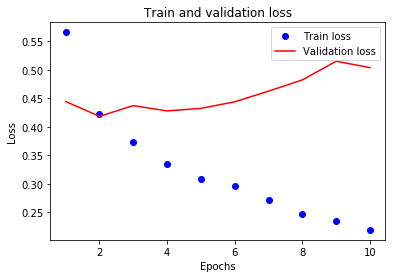

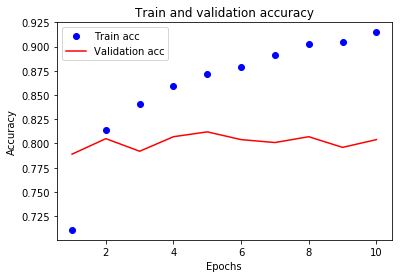

In [25]:
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_validate, y_validate))
plot_hist(history)

### Evaluate model

In [26]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 35s 1ms/step
[0.4769436262226105, 0.81288]


### TPU version

只能在 Google CoLab 上面跑

In [27]:
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# strategy = tf.contrib.tpu.TPUIDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER))

# tpu_model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

# history = tpu_model.fit(X_train, y_train, epochs=8, batch_size=160, validation_data=(X_validate, y_validate))
# plot_history(history)

# results = tpu_model.evaluate(test_data, test_labels)

# 11. Multiple-layers RNN

### Build model

預設上 RNN 只回傳最後一個 output，很多層時，每一層需要前一級的全部輸出，所以除了最後一層以外的其他層都要加上 `return_sequences=True`

In [28]:
# 先清除掉前面的 model
model = None
K.clear_session()

model = keras.Sequential()
model.add(Embedding(vocab_size, 32))
model.add(LSTM(32, return_sequences=True)) # 每一層都要 return_sequences=True
model.add(LSTM(32, return_sequences=False)) # 只有最後一層是 return_sequences=False
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 336,673
Trainable params: 336,673
Non-trainable params: 0
_________________________________________________________________


### Train model and make plot

Train on 24000 samples, validate on 1000 samples
Epoch 1/10
24000/24000 [==============================] - 135s 6ms/step - loss: 0.4473 - acc: 0.7797 - val_loss: 0.3347 - val_acc: 0.8520
Epoch 2/10
24000/24000 [==============================] - 149s 6ms/step - loss: 0.2698 - acc: 0.8916 - val_loss: 0.3494 - val_acc: 0.8410
Epoch 3/10
24000/24000 [==============================] - 140s 6ms/step - loss: 0.2033 - acc: 0.9227 - val_loss: 0.3387 - val_acc: 0.8500
Epoch 4/10
24000/24000 [==============================] - 126s 5ms/step - loss: 0.1550 - acc: 0.9440 - val_loss: 0.3648 - val_acc: 0.8510
Epoch 5/10
24000/24000 [==============================] - 129s 5ms/step - loss: 0.1143 - acc: 0.9627 - val_loss: 0.5024 - val_acc: 0.8400
Epoch 6/10
24000/24000 [==============================] - 132s 6ms/step - loss: 0.0958 - acc: 0.9688 - val_loss: 0.5321 - val_acc: 0.8290
Epoch 7/10
24000/24000 [==============================] - 131s 5ms/step - loss: 0.0696 - acc: 0.9786 - val_loss: 0.5574 - v

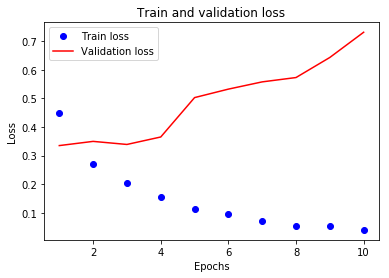

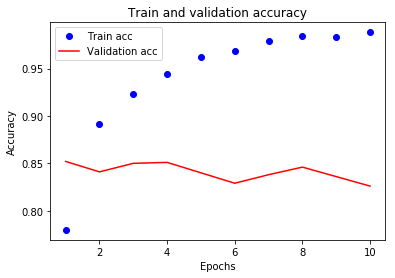

In [29]:
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_validate, y_validate))
plot_hist(history)

### Evaluate model

In [30]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 50s 2ms/step
[0.8054640356588364, 0.812]


# 12. Bi-directional RNN

把 `LSTM()` 放到 `Bidirectional()` 就可以建立 bi-directional RNN

### 一層 bi-directional RNN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________
Train on 24000 samples, validate on 1000 samples
Epoch 1/10
24000/24000 [==============================] - 120s 5ms/step - loss: 0.4736 - acc: 0.7624 - val_loss: 0.3504 - val_acc: 0.8300
Epoch 2/10
24000/24000 [==============================] - 118s 5ms/step - loss: 0.2749 - acc: 0.8903 - val_loss: 0.3432 - val_acc: 0.8420
Epoch 3/10
24000/24000 [==============================] - 118s 5ms/step - l

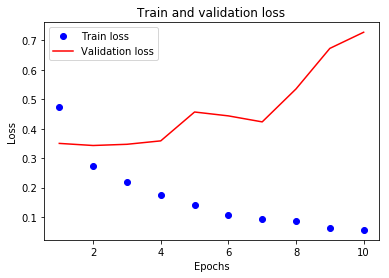

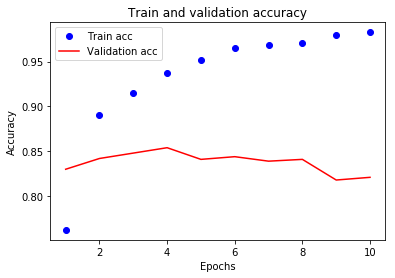

25000/25000 [==============================] - 43s 2ms/step
[0.7594424515581131, 0.81852]


In [31]:
# Build model
model = None
K.clear_session()

model = keras.Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_validate, y_validate))
# Make plot
plot_hist(history)

# Evaluate model
results = model.evaluate(test_data, test_labels)
print(results)

### 多層 bi-directional RNN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 361,537
Trainable params: 361,537
Non-trainable params: 0
_________________________________________________________________
Train on 24000 samples, validate on 1000 samples
Epoch 1/10
24000/24000 [==============================] - 247s 10ms/step - loss: 0.4506 - acc: 0.7765 - val_loss: 0.3252 - val_acc: 0.8570
Epoch 2/10
24000/24000 [==============================] - 246s 10ms/step - loss:

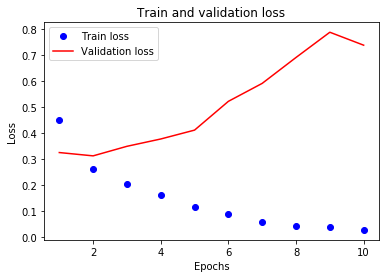

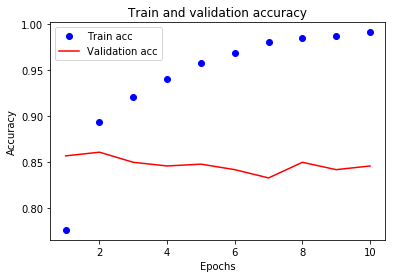

25000/25000 [==============================] - 82s 3ms/step
[0.8673149287843704, 0.81736]


In [32]:
# Build model
model = None
K.clear_session()

model = keras.Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_validate, y_validate))
# Make plot
plot_hist(history)

# Evaluate model
results = model.evaluate(test_data, test_labels)
print(results)

# 13. Pretrained embedding

不要自己訓練 word embedding，而改用別人訓練好的

* [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) 用大量資料先訓練了 word embedding

去 pretrained embedding 中找有沒有 reviews 裡面用到的單字，如果有找到就把 word embedding 設成 pretrained embedding 的結果，如果找不到就設成 0 或很小的數字

In [33]:
# Randomize pretrained embedding matrix with very small numbers
pretrained_embedding_matrix = (np.random.rand(vocab_size, 100) - 0.5) / 1e4

# Initialize pretrained embedding matrix to all zeros
# pretrained_embedding_matrix = np.zeros((vocab_size, 100))

### Load pretrained embedding

In [34]:
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in word_index:
            embs = np.asarray(values[1:], dtype='float32')
            if word_index[word] >= vocab_size:
                continue
            pretrained_embedding_matrix[word_index[word]] = embs

用 `trainable=False` 可以防止 word embedding 被更新
* 可以減少參數的數量
* Train data 少的時候，參數數量就不能太多，所以可以加上這個

### FFNN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________
Train on 24000 samples, validate on 1000 samples
Epoch 1/10
24000/24000 [==============================] - 10s 396us/step - loss: 0.6082 - acc: 0.6975 - val_loss: 0.4869 - val_acc: 0.7790
Epoch 2/10
24000/24000 [==============================] - 9s 381us/step - lo

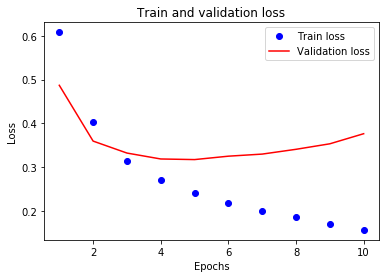

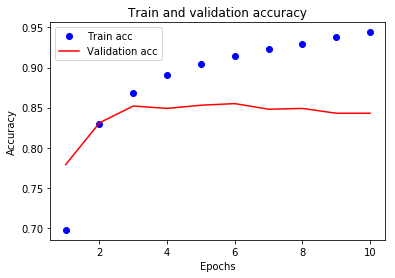

25000/25000 [==============================] - 1s 39us/step
[0.4191895386457443, 0.84116]


In [35]:
# Build model
model= None
K.clear_session()

model = keras.Sequential()
model.add(Embedding(vocab_size, 100, weights=[pretrained_embedding_matrix]))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation=tf.nn.relu))
model.add(Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

### Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_validate, y_validate))
### Make plot
plot_hist(history)

# Evaluate model
results = model.evaluate(test_data, test_labels)
print(results)

### RNN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________
Train on 24000 samples, validate on 1000 samples
Epoch 1/10
24000/24000 [==============================] - 74s 3ms/step - loss: 0.5178 - acc: 0.7340 - val_loss: 0.3923 - val_acc: 0.8290
Epoch 2/10
24000/24000 [==============================] - 82s 3ms/step - loss: 0.3425 - acc: 0.8524 - val_loss: 0.3388 - val_acc: 0.8540
Epoch 3/10
24000/24000 [==============================] - 78s 3ms/step - 

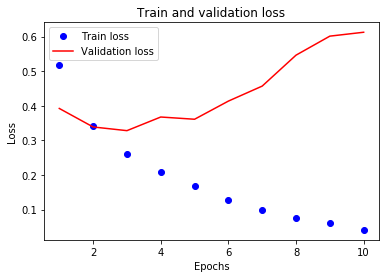

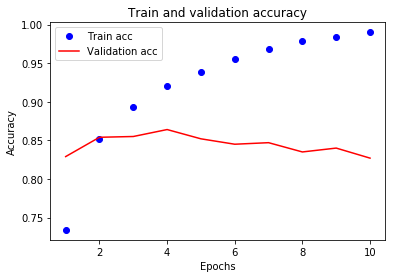

25000/25000 [==============================] - 32s 1ms/step
[0.6496296697235108, 0.83176]


In [36]:
# Build model
model = None
K.clear_session()

model = keras.Sequential()
model.add(Embedding(vocab_size, 100, weights=[pretrained_embedding_matrix]))
model.add(LSTM(32))
# model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_validate, y_validate))
### Make plot
plot_hist(history)

# Evaluate model
results = model.evaluate(test_data, test_labels)
print(results)

# 14. Summary

* Basic preprocessing of NLP data
  * Tokenize words
  * Create a dictionary that maps words to unique IDs
  * Convert words to ID
  * Pad/truncate sequences to unified lengths
* Building a model using Keras
  * Design model structure
  * Add layers
  * Define loss
  * Define optimizer
* Training and evaluation
  * Create a plot to clearly observe training progress
  * Evaluate on test set
* Improvements to the model
  * Dropout
  * Recurrent
  * Pretrained embeddings
  * Mixture of the above